https://dspguru.com/files/QuadSignals.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift

from physdim import units as u
from physdim import constants as K
from physdim import PhysicalValue
PhysicalValue.repr_is_str = True

In [2]:
T = 100*u.usec
fo = 850*u.kHz
BW = 400*u.kHz

In [3]:
IPRr = 0.5*K.c/BW
IPRr

374.7405725 m

# Transmit Signal

$$
\begin{align}
f(t) &= f_s + \gamma\,T \qquad
\text{where}\quad f_s = f_o - \frac{BW}{2}\quad
\text{and}\quad\gamma = \frac{BW}{T} \\
\omega(t) &= 2\pi f(t) = 2\pi\left(f_s + \gamma\,T\right)\\
\\
\phi(t) &= \phi_o + \int_0^t \omega(\tau)\,d\tau = \phi_o + 2\pi\left(f_s\,t + \frac{\gamma\,t^2}{2}\right)\\
\\
\sigma_{tx}(t) &= \tau\left[0\le t\le T\right]\;\sin\left[\phi_o + 2\pi\left(f_s\,t + \frac{\gamma\,t^2}{2}\right)\right]
\end{align}
$$

In [4]:
fs = fo-BW/2
gamma = BW/T
phi_o = 0

def xmit(t):
    if t<0*u.sec or t>T:
        return 0
    return np.sin(phi_o + 2*np.pi*(t*(fs+0.5*gamma*t)))    

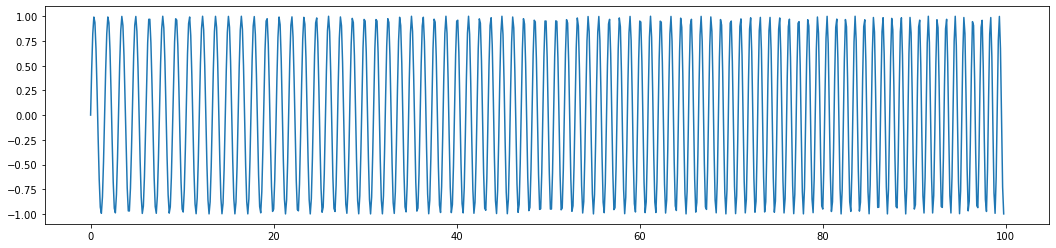

In [5]:
Fs = 10*fo
t = [i/Fs for i in range(int(Fs*T))]
t_plt = [tt.usec for tt in t]
s_plt = [xmit(tt) for tt in t]

plt.figure(figsize=(18,4))
plt.plot(t_plt,s_plt)
plt.show()

## Return Signal

In [44]:
# List of signal reflectors
#  Each reflector is a tuple containing range and relative cross section
reflectors = (
    (500*u.nmi, 1.0),
    (503*u.nmi, 0.2),
    (510*u.nmi, 0.5),
    (485*u.nmi, 0.75),
)

def rcv(t):
    return sum( A * xmit(t-2*rs/K.c) for rs,A in reflectors)

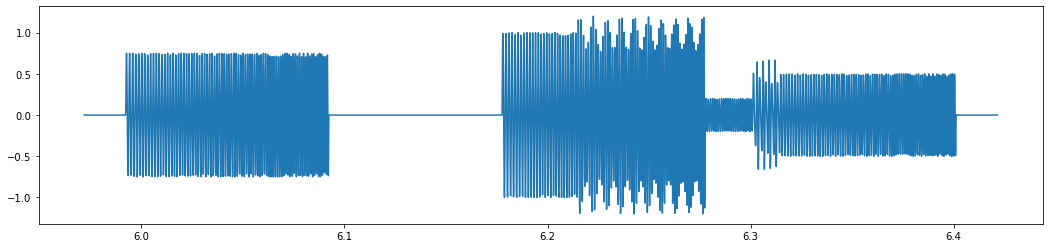

In [45]:
round_trip_times = tuple(2*Rs/K.c for Rs,_ in reflectors)
Tr_s = min(round_trip_times)
Tr_e = max(round_trip_times) + T
Tp_s = 1.05*Tr_s - 0.05*Tr_e
Tp_e = 1.05*Tr_e - 0.05*Tr_s

t = [Tp_s + i/Fs for i in range(int(Fs*(Tp_e-Tp_s)))]
t_plt = [tt.msec for tt in t]
s_plt = [rcv(tt) for tt in t]

plt.figure(figsize=(18,4))
plt.plot(t_plt,s_plt)
plt.show()

# Chirp

$$
\begin{align}
f_{chirp}(t) &= f_c \\
\phi_{chirp}(t) &= \phi_{oc} + 2\pi f_c\,t\\
\sigma_{chirp}(t) &= \sin\left(\phi_{oc} + 2\pi f_c\,t\right)
\end{align}
$$

In [46]:
fc=fo
phi_oc = 0
def demod_chirp(t):
    return np.sin(phi_oc + 2*np.pi*fc*t)

def rcv_chirp(t):
    return rcv(t)*demod_chirp(t)

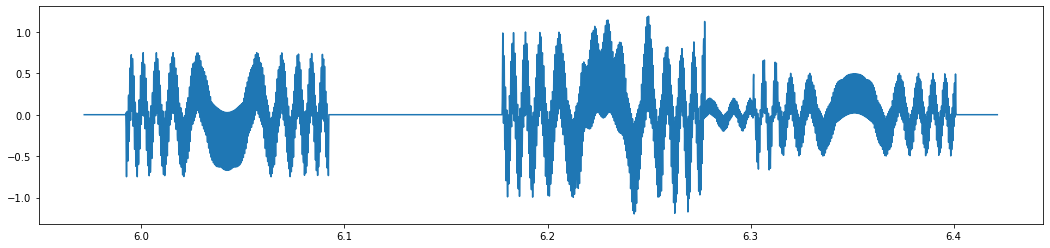

In [47]:
s = [rcv_chirp(tt) for tt in t]
plt.figure(figsize=(18,4))
plt.plot(t_plt,s)
plt.show()

## Pass through IF filter 

In [48]:
BW_if = 2000*u.kHz

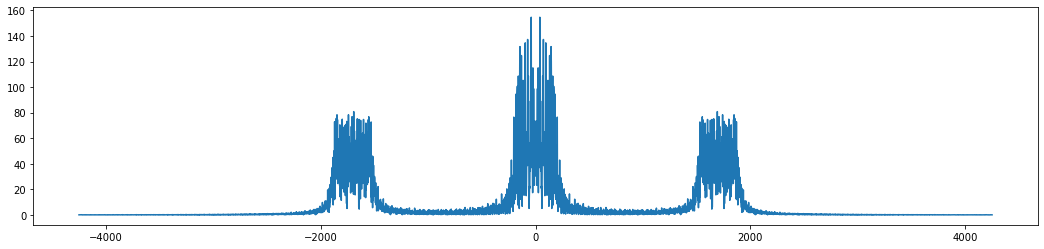

In [49]:
# convert to frequency domain
S = fft(s)
f = fftfreq(len(S),1/Fs)
f_plt = fftshift(f)*u.Hz
S_plt = fftshift(S)

plt.figure(figsize=(18,4))
plt.plot(f_plt.kHz,np.abs(S_plt))
plt.show()

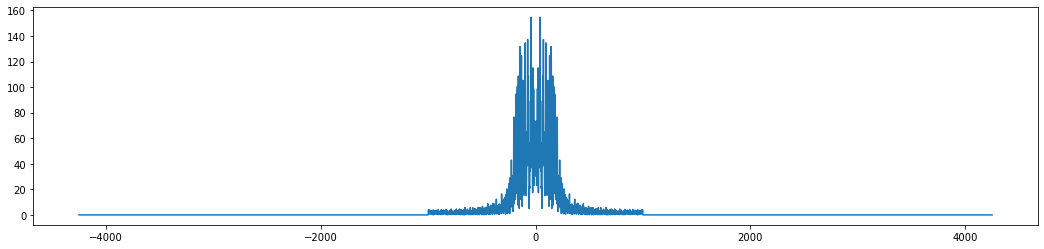

In [50]:
# apply IF filter
Sif = S
Sif[np.abs(f) > BW_if/2] = 0

plt.figure(figsize=(18,4))
plt.plot(f_plt.kHz,fftshift(np.abs(Sif)))
plt.show()

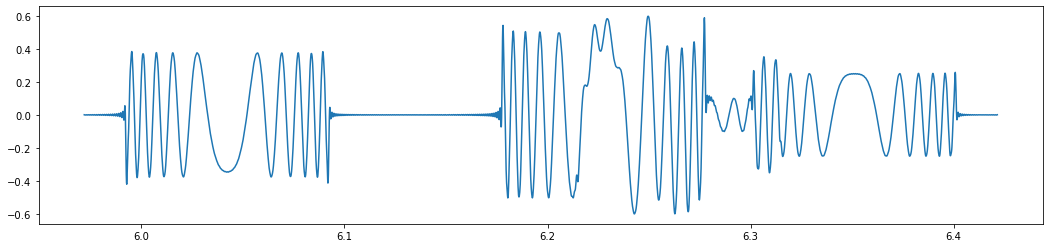

In [51]:
# convert back to time domain
s_chirp = np.real(ifft(Sif))
t_chirp = t_plt * u.msec

plt.figure(figsize=(18,4))
plt.plot(t_plt,s_chirp)
plt.show()

# Stretch

$$
\begin{align}
f_{stretch}(t) &= f_{so} + \gamma\,t \\
\phi_{stretch}(t) &= \phi_{os} + 2\pi f_{so}\,t + \pi\gamma\,t^2\\
\sigma_{chirp}(t) &= \sin\left(\phi_{os} + 2\pi f_{so}\,t + \pi\gamma\,t^2\right)
\end{align}
$$

In [52]:
fso=fo-gamma*(0.5*(Tr_s+Tr_e)-Tp_s)
phi_os = 0

def demod_stretch(t):
    return np.sin(phi_os + 2*np.pi*t*(fso + 0.5*gamma*t))

def rcv_stretch(t):
    return rcv(t)*demod_stretch(t-Tp_s)

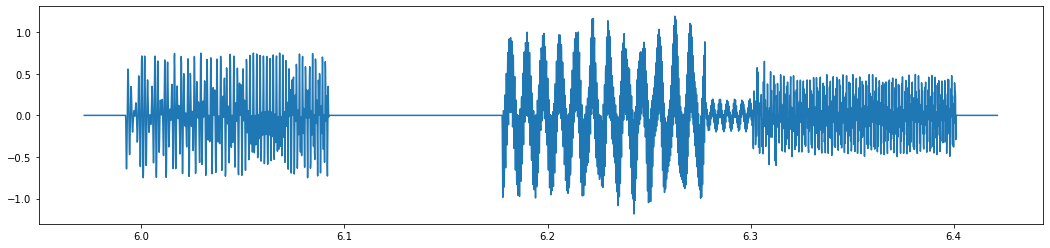

In [53]:
s = [rcv_stretch(tt) for tt in t]

plt.figure(figsize=(18,4))
plt.plot(t_plt,s)
plt.show()

## Pass through IF filter

In [54]:
BW_if = 1400*u.kHz

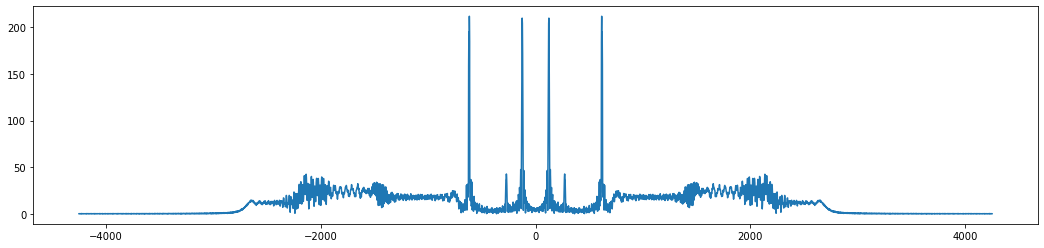

In [55]:
# convert to frequency domain
S = fft(s)
f = fftfreq(len(S),1/Fs)
f_plt = fftshift(f)*u.Hz
S_plt = fftshift(S)

plt.figure(figsize=(18,4))
plt.plot(f_plt.kHz,np.abs(S_plt))
plt.show()

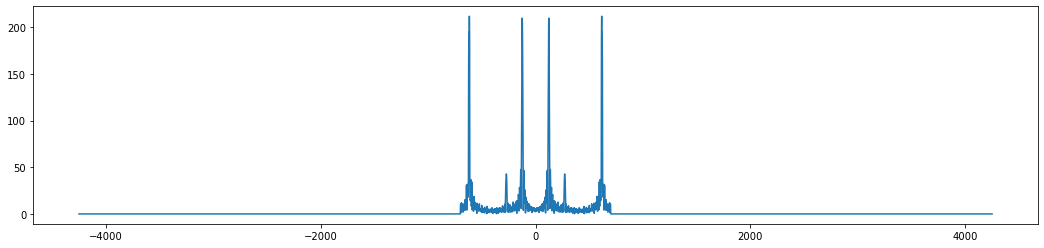

In [56]:
# apply IF filter
Sif = S
Sif[np.abs(f) > BW_if/2] = 0

plt.figure(figsize=(18,4))
plt.plot(f_plt.kHz,fftshift(np.abs(Sif)))
plt.show()

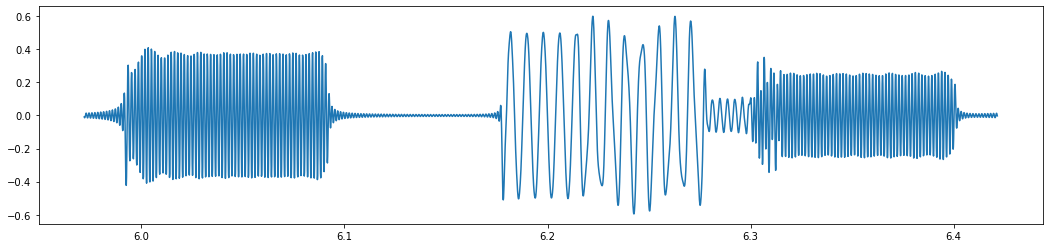

In [57]:
# convert back to time domain
s_stretch = np.real(ifft(Sif))
t_stretch = t_plt * u.msec

plt.figure(figsize=(18,4))
plt.plot(t_plt,s_stretch)
plt.show()

## Deskew

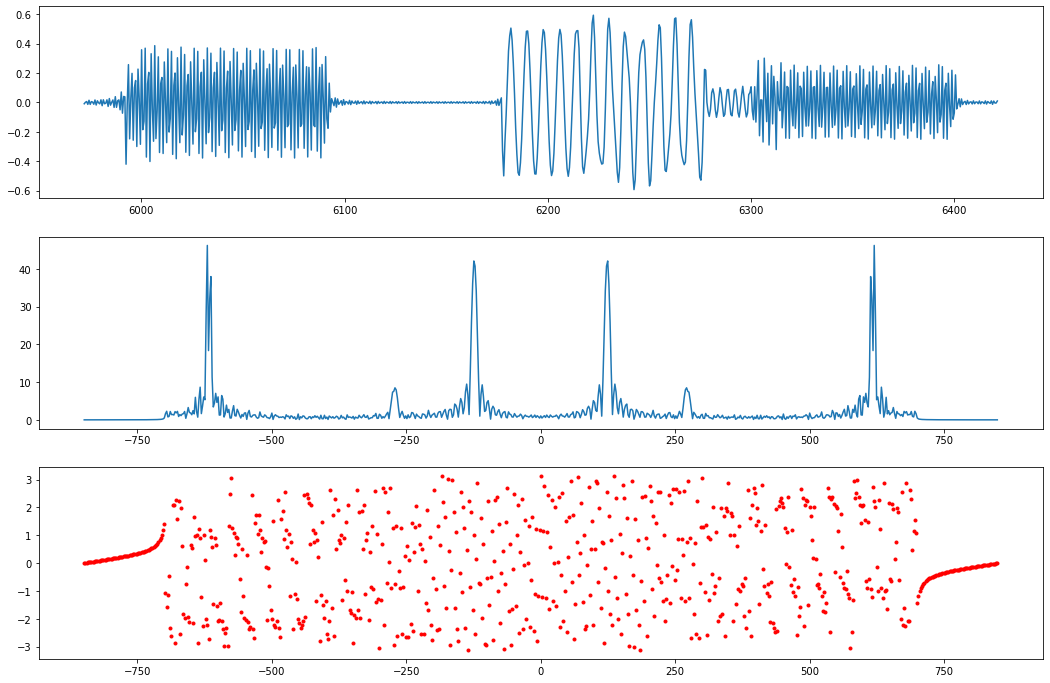

In [84]:
# Use FFT to create spectrum
Fs_data = 1/(t[1]-t[0])
Fs_desired = 2*fo
osf = int(Fs_data/Fs_desired+0.25)

s_sampled = s_stretch[0:-1:osf]
t_sampled = t_stretch[0:-1:osf]
nsamp = len(s_sampled)

S_sampled = fft(s_sampled)
f_sampled = fftfreq(nsamp, osf/Fs)

fig,ax = plt.subplots(3,1,figsize=(18,12))
ax[0].plot(t_sampled.usec,s_sampled)
ax[1].plot(fftshift(f_sampled.kHz),fftshift(np.abs(S_sampled)))
ax[2].plot(fftshift(f_sampled.kHz),fftshift(np.angle(S_sampled)),'.r')
plt.show()

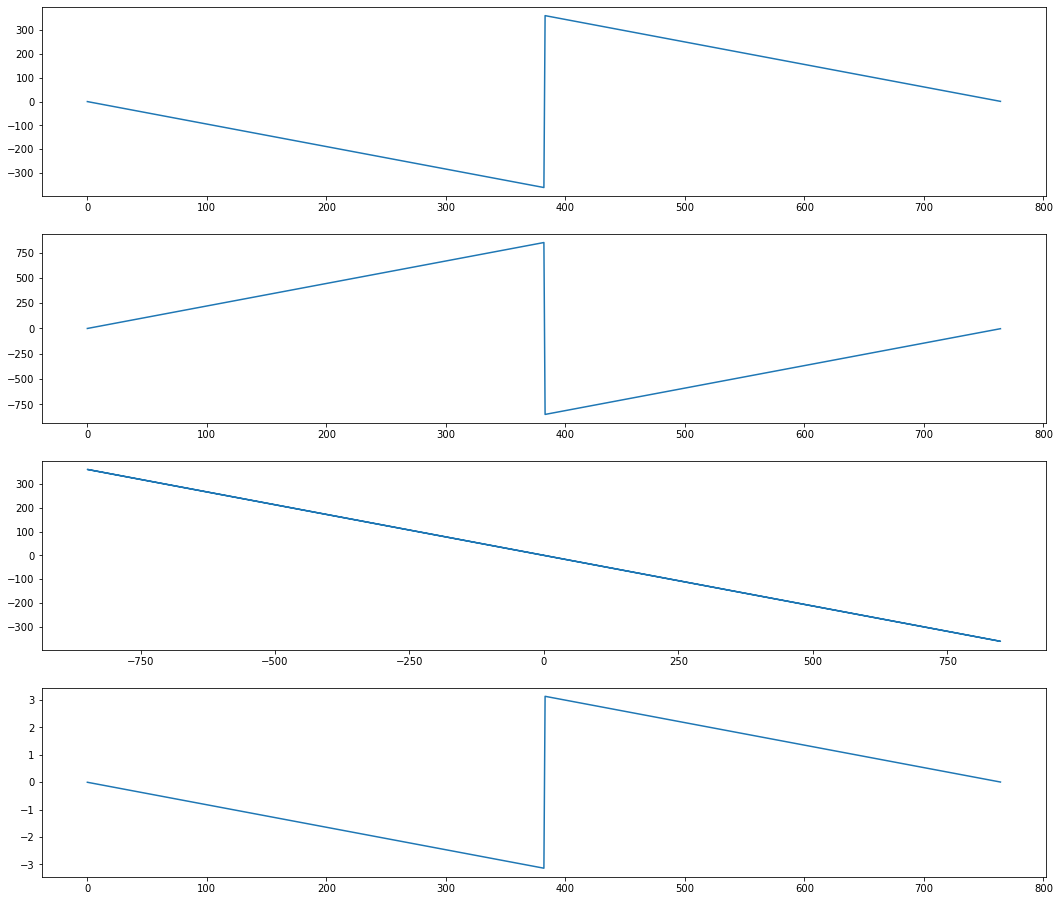

In [85]:
fig,axs = plt.subplots(4,1,figsize=(18,16))
dt = -f_sampled*(Fs/osf)/gamma
w = np.exp(-2j*np.pi*f_sampled*osf/Fs)
axs[0].plot(dt)
axs[1].plot(f_sampled.kHz)
axs[2].plot(f_sampled.kHz,dt)
axs[3].plot(np.angle(w))
plt.show()

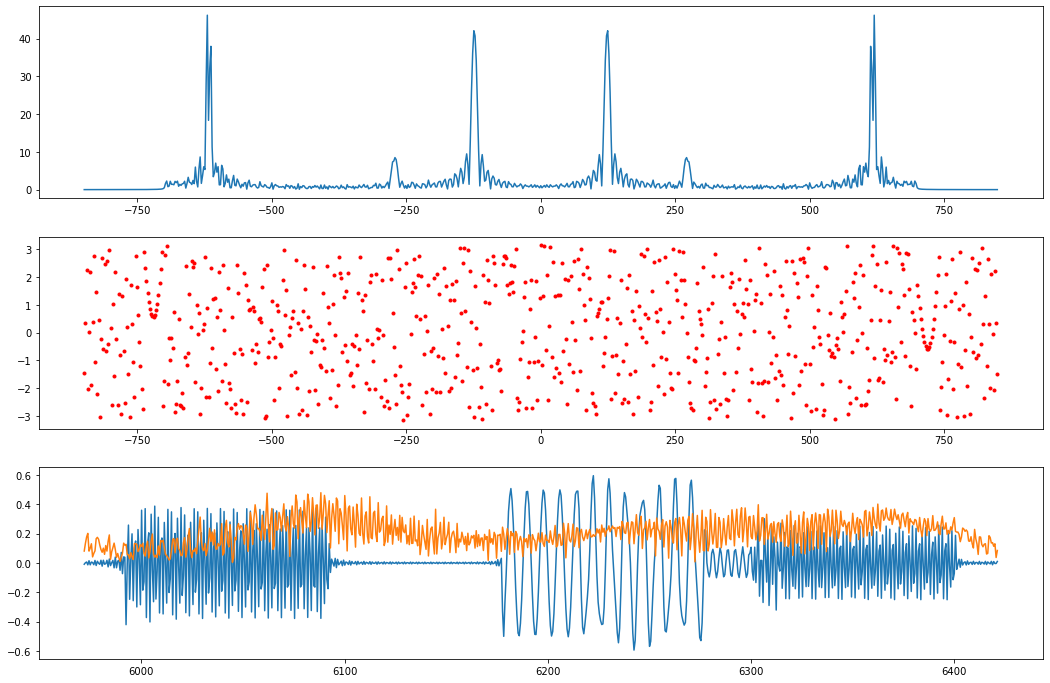

In [86]:
# timeshift each frequency based on chirp slope
w = np.exp(-2j*np.pi*f_sampled*osf/Fs)
w = np.exp(-2j*np.pi*f_sampled*osf*20/Fs)
w = np.exp(2j*np.pi*f_sampled*osf*f_sampled/gamma)

S_deskewed = S_sampled * w

s_deskewed = ifft(S_deskewed)

fig,ax = plt.subplots(3,1,figsize=(18,12))
ax[0].plot(fftshift(f_sampled.kHz),fftshift(np.abs(S_deskewed)))
ax[1].plot(fftshift(f_sampled.kHz),fftshift(np.angle(S_deskewed)),'.r')
ax[2].plot(t_sampled.usec,s_sampled)
ax[2].plot(t_sampled.usec,np.abs(s_deskewed))
plt.show()

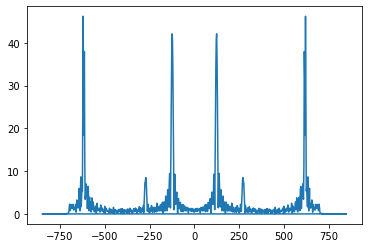

In [87]:
plt.plot(f_sampled.kHz,np.abs(S_sampled))

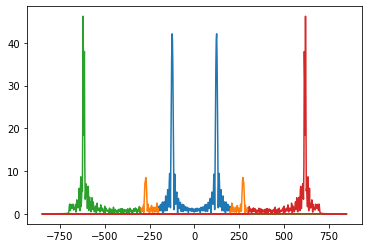

In [99]:
S1=S_sampled.copy()
S1[np.abs(f_sampled)>200*u.kHz]=0
S2=S_sampled-S1
S2[np.abs(f_sampled)>300*u.kHz]=0
S3b=S_sampled-S1-S2
S3b[f_sampled<0*u.Hz] = 0
S3a=S_sampled-S1-S2-S3b
plt.plot(f_sampled.kHz,np.abs(S1))
plt.plot(f_sampled.kHz,np.abs(S2))
plt.plot(f_sampled.kHz,np.abs(S3a))
plt.plot(f_sampled.kHz,np.abs(S3b))
plt.show()

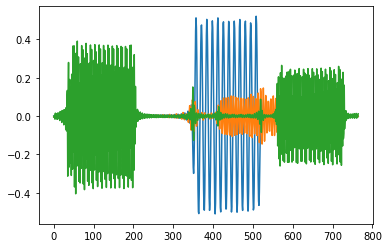

In [104]:
s1 = ifft(S1)
s2 = ifft(S2)
s3a = ifft(S3a)
s3b = ifft(S3b)
plt.plot(np.real(s1))
plt.plot(np.real(s2))
plt.plot(np.real(s3b+s3a))
plt.show()